# DATA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm 
import torch

In [2]:
mt_df = pd.read_csv("MetaData.csv")
mt_df.head()

,id,gender,age,county,ptb,remarks
0,1000,male,31,Shenxhen,0,normal
1,1001,male,64,Shenxhen,0,normal
2,1002,male,35,Shenxhen,0,normal
3,1003,male,32,Shenxhen,1,"STB,ATB,tuberculosis pleuritis"
4,1004,male,2,Shenxhen,1,secondary PTB in the bilateral upper field


In [3]:
mask_dir = './Chest-X-Ray/Chest-X-Ray/mask/'
image_dir = './Chest-X-Ray/Chest-X-Ray/image/'

mask_files = os.listdir(mask_dir)
image_files = os.listdir(image_dir)

print(mask_files[:5])
print(image_files[:5])

print(len(mask_files))
print(len(image_files))

['1001.png', '1003.png', '1006.png', '1009.png', '1010.png']
['1001.png', '1003.png', '1006.png', '1009.png', '1010.png']
704
704


In [45]:
def mask_image_show(idx):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1,2,1)
    mask_img = cv2.imread(mask_dir + mask_files[idx])
    
    plt.axis('off')
    plt.title('MASK_IMG')
    plt.imshow(mask_img, cmap='gray')
    
    plt.subplot(1,2,2)
    image_img = cv2.imread(image_dir + image_files[idx])
    plt.axis('off')
    plt.title('ORGIN_IMG')
    plt.imshow(image_img, cmap='gray')
    
    plt.show()

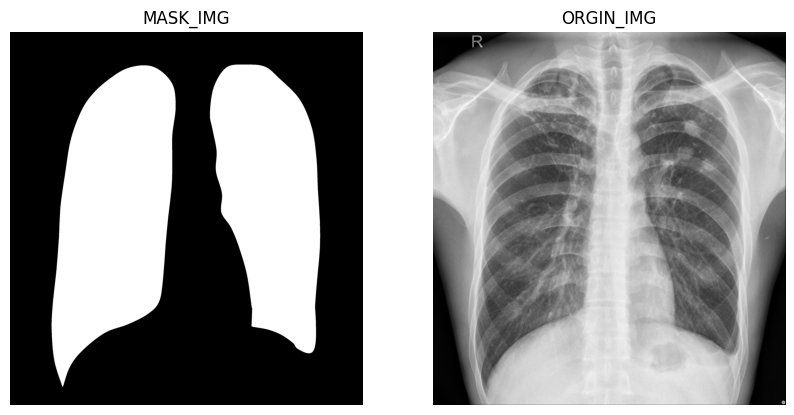

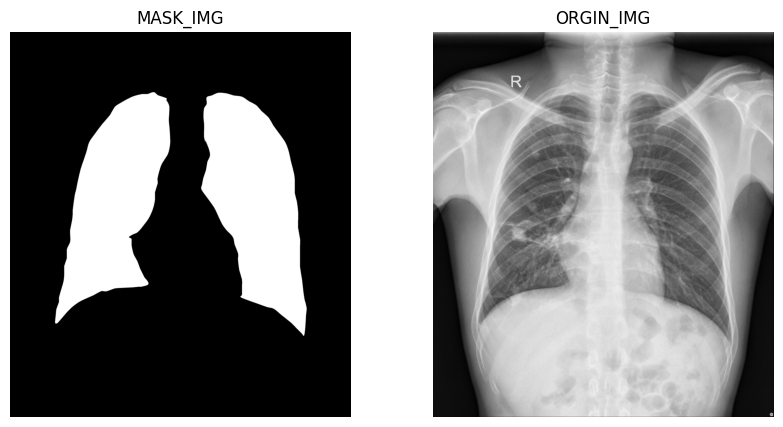

In [46]:
mask_image_show(1)
mask_image_show(2)

In [83]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

In [142]:
class ChestXRayDataset(Dataset):
    def __init__(self, image_dir, mask_dir, input_transform, mask_transform):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.input_transform = input_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = self.input_transform(image)
        mask = self.mask_transform(mask)

        return image, mask

In [143]:
input_transform = transforms.Compose([
    transforms.ToPILImage(),      
    transforms.Resize((572, 572)),
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.5], std=[0.5])
])

mask_transform = transforms.Compose([
    transforms.ToPILImage(),      
    transforms.Resize((572, 572)),
    transforms.CenterCrop((388, 388)),
    transforms.ToTensor(),        
])

dataset = ChestXRayDataset(image_dir="./Chest-X-Ray/Chest-X-Ray/image/",
                            mask_dir="./Chest-X-Ray/Chest-X-Ray/mask/",
                           input_transform=input_transform, mask_transform=mask_transform)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in dataloader:
    print(f"이미지 크기: {images.shape}, 마스크 크기: {masks.shape}")
    break

이미지 크기: torch.Size([8, 3, 572, 572]), 마스크 크기: torch.Size([8, 1, 388, 388])


# Model

In [144]:
class UNet(nn.Module):
    def __init__(self, in_chanels=1, out_channels=2):
        super().__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_chanels, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )

        self.maxpool1 = nn.MaxPool2d((2,2))

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )

        self.maxpool2 = nn.MaxPool2d((2,2))
        
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )

        self.maxpool3 = nn.MaxPool2d((2,2))
    
        self.encoder4= nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )

        self.maxpool4 = nn.MaxPool2d((2,2))

        self.encoder5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )

        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0)

        self.decoder1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)

        self.decoder2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)

        self.decoder3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)

        self.decoder4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=1, stride=1, padding=0)
        )
        
    def forward(self, x):
        x_1 = self.encoder1(x)
        x = self.maxpool1(x_1)
        x_2 = self.encoder2(x)
        x = self.maxpool2(x_2)
        x_3 = self.encoder3(x)
        x = self.maxpool3(x_3)
        x_4 = self.encoder4(x)
        x = self.maxpool4(x_4)
        x_5 = self.encoder5(x)
        
        x = self.upconv1(x_5)
        x = torch.cat([x, TF.center_crop(x_4, [56, 56])], dim=1)
        x = self.decoder1(x)

        x = self.upconv2(x)
        x = torch.cat([x, TF.center_crop(x_3, [104, 104])], dim=1)
        x = self.decoder2(x)

        x = self.upconv3(x)
        x = torch.cat([x, TF.center_crop(x_2, [200, 200])], dim=1)
        x = self.decoder3(x)

        x = self.upconv4(x)
        x = torch.cat([x, TF.center_crop(x_1, [392, 392])], dim=1)
        x = self.decoder4(x)
        
        return x

# TRAIN

In [145]:
import torch.optim as optim
from torch.utils.data import random_split, DataLoader

In [154]:
device = "cuda:3"
Epoch = 20
lr = 1e-4
batch_size =16
image_size = 572

In [155]:
dataset = ChestXRayDataset(
    image_dir="./Chest-X-Ray/Chest-X-Ray/image/",
    mask_dir="./Chest-X-Ray/Chest-X-Ray/mask/",
    input_transform=input_transform,
    mask_transform=mask_transform
)

dataset_size = len(dataset)
train_size = int(0.9 * dataset_size)  # 90%
test_size = dataset_size - train_size  # 10%

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [156]:
model = UNet(in_chanels=3, out_channels=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [157]:
def train():
    model.train()
    train_loss = []
    for epoch in range(Epoch):
        epoch_loss = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, masks.squeeze(dim=1).long())
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)

        print(f"Epoch {epoch+1/Epoch}, Loss : {avg_loss:.4f}")

    print("training complete!")

train()

Epoch 0.05, Loss : 0.4641
Epoch 1.05, Loss : 0.2797
Epoch 2.05, Loss : 0.2364
Epoch 3.05, Loss : 0.1755
Epoch 4.05, Loss : 0.1501
Epoch 5.05, Loss : 0.1261
Epoch 6.05, Loss : 0.1084
Epoch 7.05, Loss : 0.1031
Epoch 8.05, Loss : 0.1013
Epoch 9.05, Loss : 0.0952
Epoch 10.05, Loss : 0.0996
Epoch 11.05, Loss : 0.0908
Epoch 12.05, Loss : 0.0909
Epoch 13.05, Loss : 0.0853
Epoch 14.05, Loss : 0.0837
Epoch 15.05, Loss : 0.0817
Epoch 16.05, Loss : 0.0789
Epoch 17.05, Loss : 0.0779
Epoch 18.05, Loss : 0.0764
Epoch 19.05, Loss : 0.0822
training complete!


In [260]:
def test(idx):
    model.eval()
    data = test_dataset[idx][0]
    mask = test_dataset[idx][1]
    
    x = data.unsqueeze(0).to(device)
    outputs = model(x)
    pred_mask = outputs.to('cpu')
    pred_mask = torch.argmax(pred_mask, dim=1).unsqueeze(0)

    return data, pred_mask[0], mask

In [283]:
def vis(idx):
    data, pred_mask, mask = test(idx)
    data = np.clip(data.numpy(), 0, 1)
    plt.figure(figsize=(10, 30))
    plt.subplot(1, 3, 1)
    plt.imshow(data.transpose(1,2,0))
    plt.axis('off')
    plt.title('ORIGN')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask.permute(1,2,0), cmap="gray")
    plt.axis('off')
    plt.title('Real')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.permute(1,2,0), cmap="gray")
    plt.axis('off')
    plt.title('Predict')
    
    plt.show()

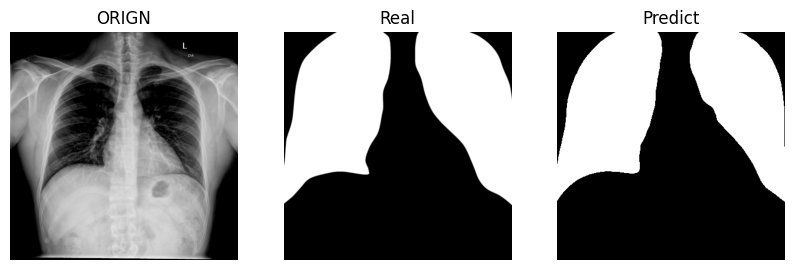

In [284]:
vis(20)